# Optimal-Fertilizer-Prediction

In [3]:
# Import the libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import pickle 

In [4]:
# Loading the datasets 
df = pd.read_csv('fertilizer_prediction.csv')

In [5]:
df.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [6]:
# Information about the train data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               10001 non-null  int64 
 1   Temparature      10001 non-null  int64 
 2   Humidity         10001 non-null  int64 
 3   Moisture         10001 non-null  int64 
 4   Soil Type        10001 non-null  object
 5   Crop Type        10001 non-null  object
 6   Nitrogen         10001 non-null  int64 
 7   Potassium        10001 non-null  int64 
 8   Phosphorous      10001 non-null  int64 
 9   Fertilizer Name  10001 non-null  object
dtypes: int64(7), object(3)
memory usage: 781.5+ KB


In [7]:
# Describing train data 
df.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,5000.000000,31.443756,61.053995,45.023398,23.138386,9.507049,21.172883
std,2887.184355,4.017619,6.615035,11.813816,11.212789,5.783578,12.317630
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,2500.000000,28.000000,55.000000,35.000000,13.000000,4.000000,11.000000
50%,5000.000000,31.000000,61.000000,45.000000,23.000000,10.000000,22.000000
75%,7500.000000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,10000.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [8]:
# Null values in train data 
df.isnull().sum()

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [9]:
# Removing id column from both train and test datasets, as it is not required further 
df = df.drop(columns = ['id'], axis = 1)

In [10]:
# Verifying 
print("Columns: ", df.columns)

Columns:  Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')


In [11]:
# Strip the spaces in column names for better handling 
df.columns = df.columns.str.replace(' ', '', regex = False)
print(df.columns)

Index(['Temparature', 'Humidity', 'Moisture', 'SoilType', 'CropType',
       'Nitrogen', 'Potassium', 'Phosphorous', 'FertilizerName'],
      dtype='object')


In [12]:
# Unique values in categorical columns 
cat_cols = df.select_dtypes(include = 'object')
for col in cat_cols:
    print("For column: ", col)
    print("Number of unique values: ", df[col].nunique())
    print("Unique values: ", df[col].unique())
    print("↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔")

For column:  SoilType
Number of unique values:  5
Unique values:  ['Clayey' 'Sandy' 'Red' 'Loamy' 'Black']
↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔
For column:  CropType
Number of unique values:  11
Unique values:  ['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']
↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔
For column:  FertilizerName
Number of unique values:  7
Unique values:  ['28-28' '17-17-17' '10-26-26' 'DAP' '20-20' '14-35-14' 'Urea']
↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔↔


In [13]:
# Numerical columns 
num_cols = df.select_dtypes(include = 'int64')

# Exploratory Data Analysis 

## Uni-variate Analysis 

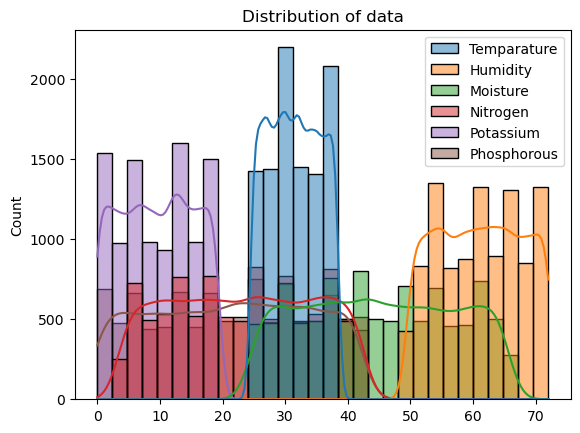

In [16]:
sns.histplot(df, kde = True, bins = 30)
plt.title("Distribution of data")
plt.show()

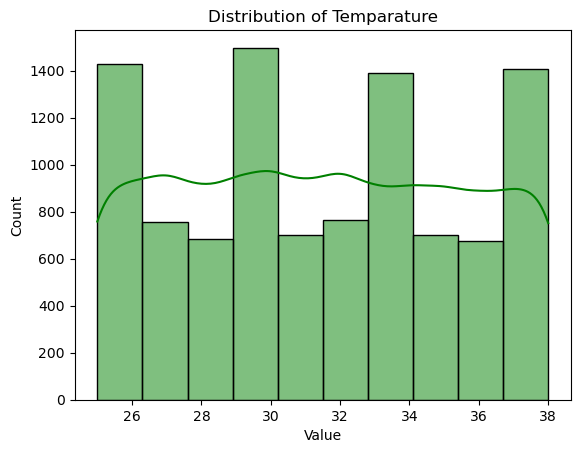

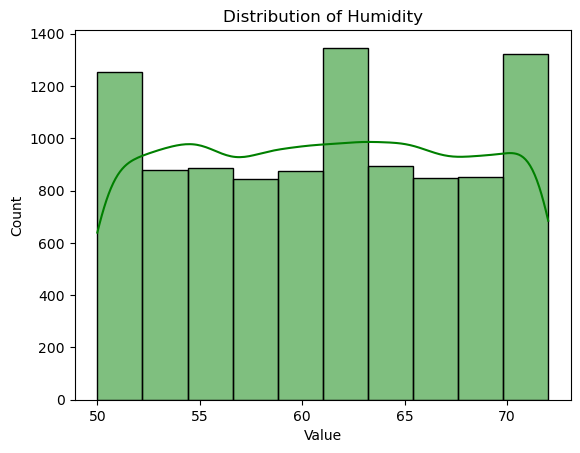

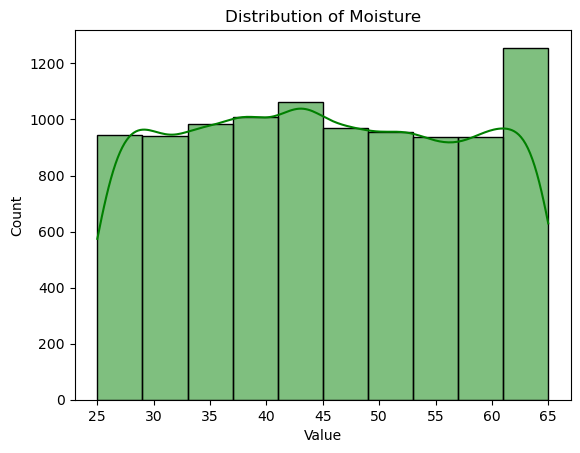

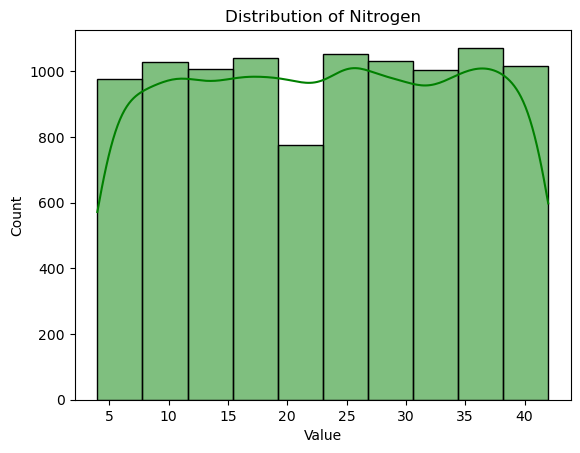

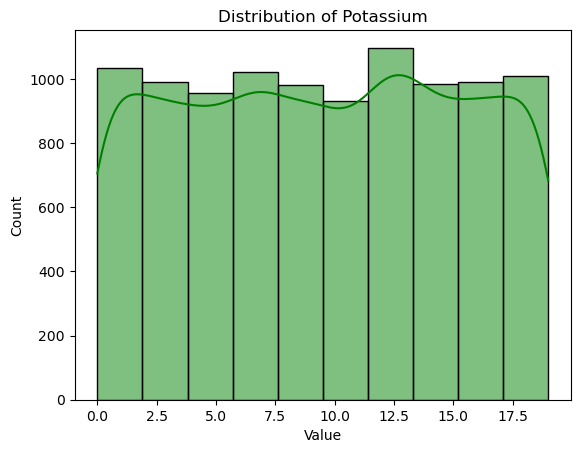

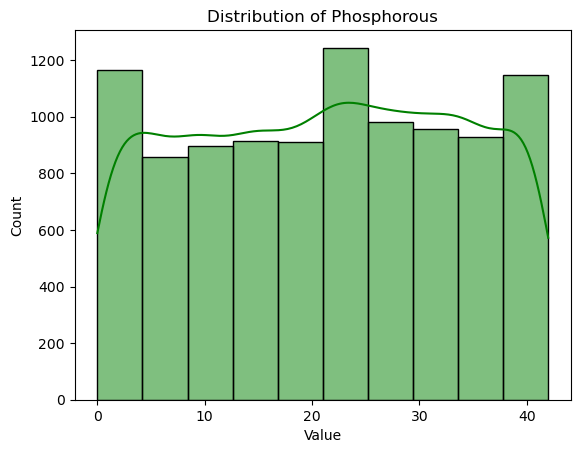

In [17]:
# Histplot for numerical columns 
for i in num_cols:
    sns.histplot(df[i], bins = 10, kde = True, color = 'green')
    plt.title(f"Distribution of {i}")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

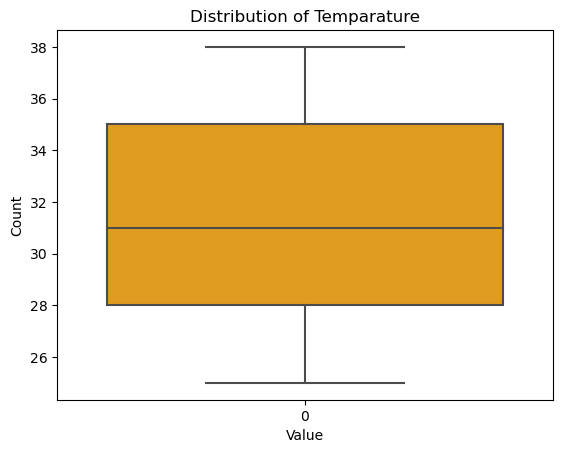

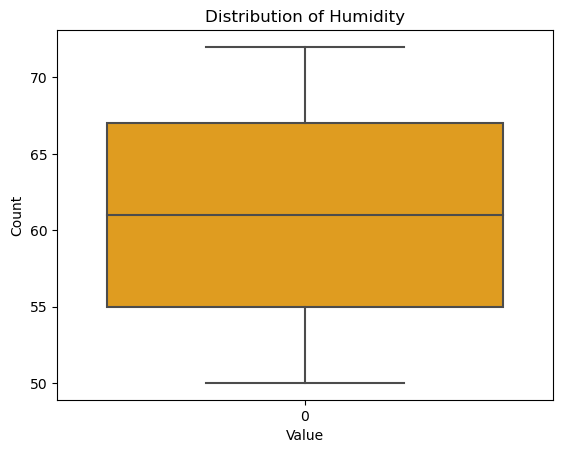

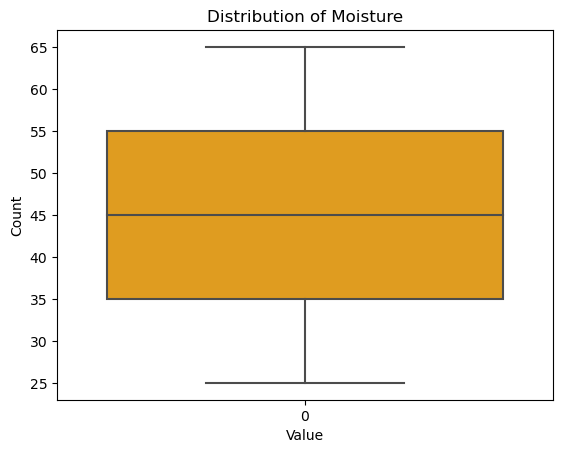

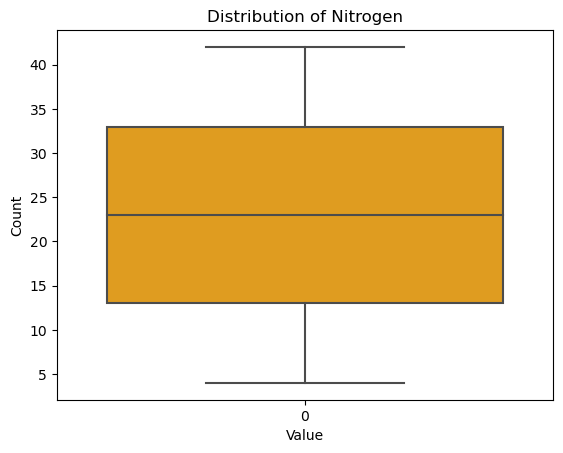

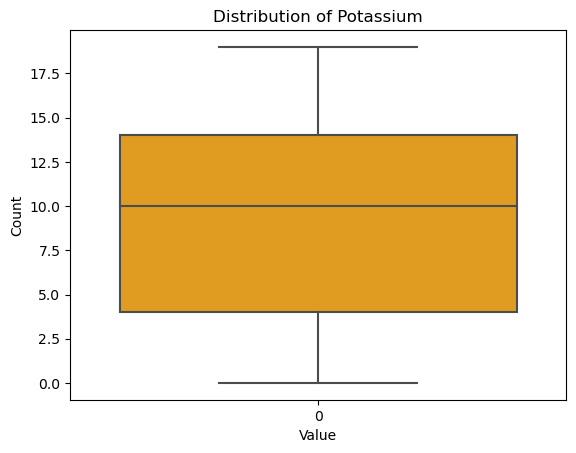

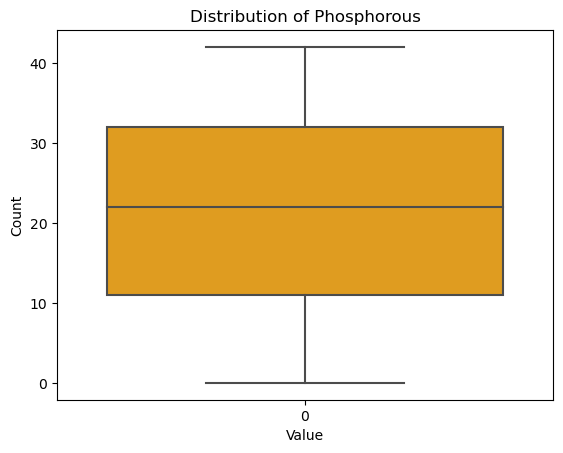

In [18]:
# Boxplot for numerical columns to find outliers 
for i in num_cols:
    sns.boxplot(df[i], color = 'orange')
    plt.title(f"Distribution of {i}")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

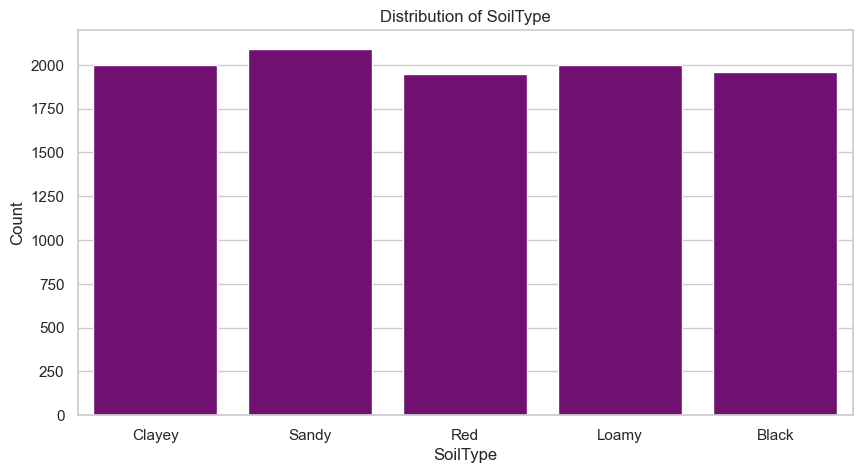

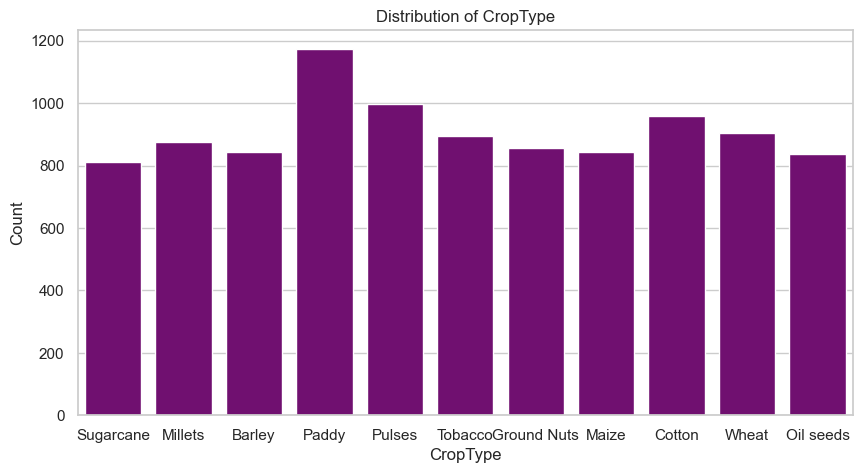

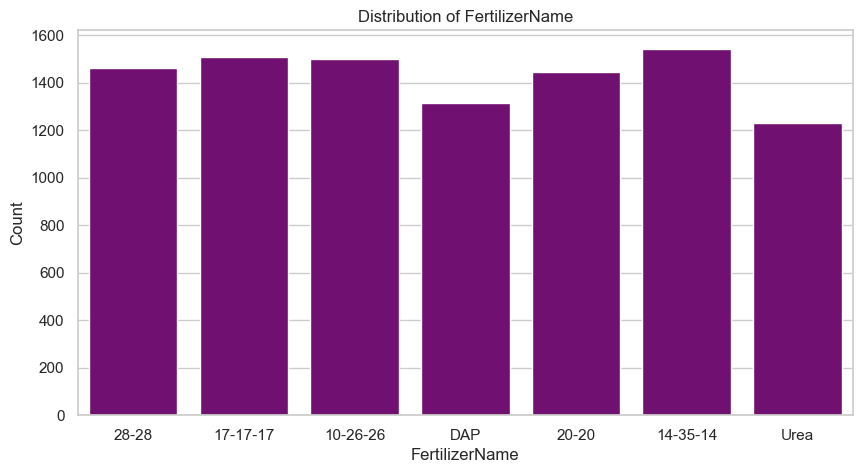

In [19]:
# Barplot for categorical columns 
for i in cat_cols:
    sns.set(style = 'whitegrid')
    plt.figure(figsize = (10, 5))
    sns.countplot(x = i, data = df, color = 'purple')
    plt.title(f"Distribution of {i}")
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.show()

## Bi-variate Analysis 

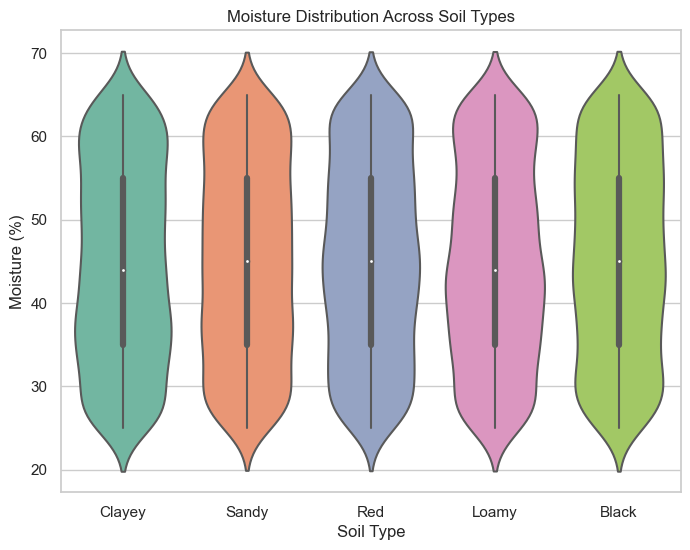

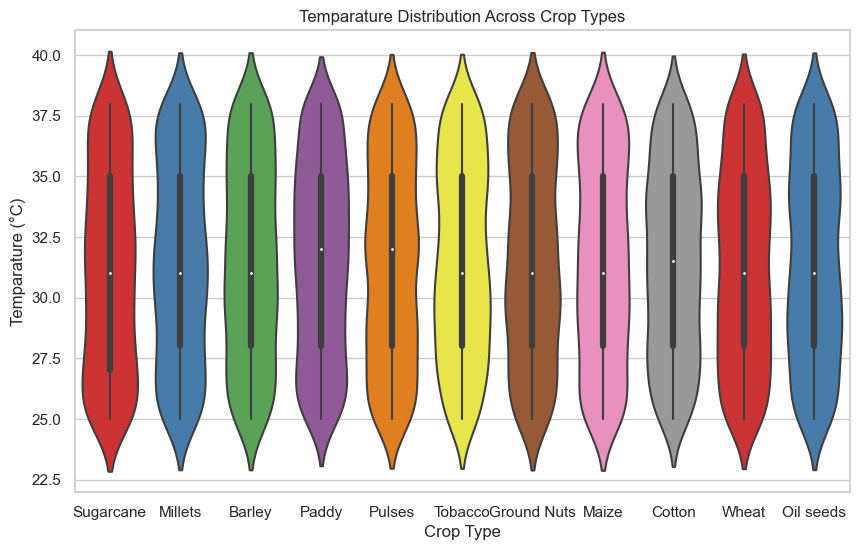

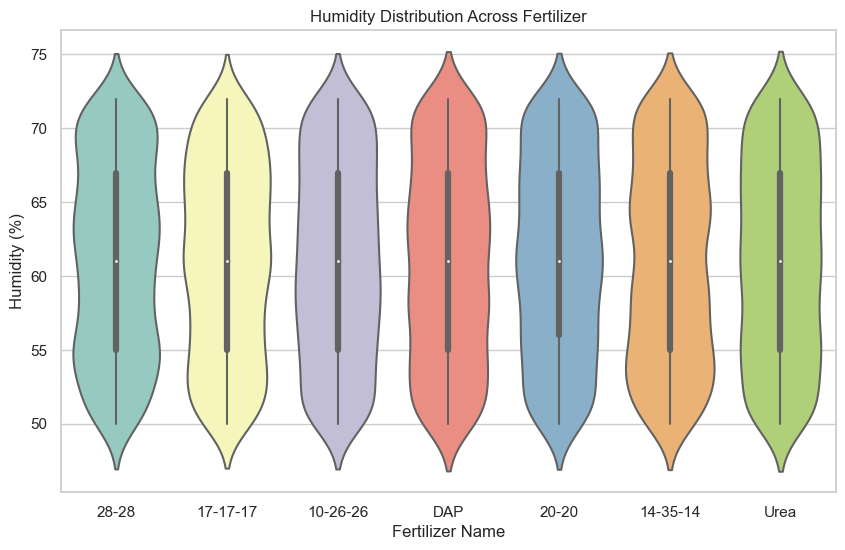

In [21]:
# Voilinplot for SoilType and Moisture
plt.figure(figsize = (8, 6))
sns.violinplot(x = 'SoilType', y = 'Moisture', data = df, palette = 'Set2')

plt.title('Moisture Distribution Across Soil Types')
plt.xlabel('Soil Type')
plt.ylabel('Moisture (%)')
plt.show()

# Voilinplot for CropType and Temparature 
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'CropType', y = 'Temparature', data = df, palette = 'Set1')

plt.title('Temparature Distribution Across Crop Types')
plt.xlabel('Crop Type')
plt.ylabel('Temparature (°C)')
plt.show()

# Voilinplot for FertilizerName and Humidity 
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'FertilizerName', y = 'Humidity', data = df, palette = 'Set3')

plt.title('Humidity Distribution Across Fertilizer')
plt.xlabel('Fertilizer Name')
plt.ylabel('Humidity (%)')
plt.show()

In [22]:
df.columns

Index(['Temparature', 'Humidity', 'Moisture', 'SoilType', 'CropType',
       'Nitrogen', 'Potassium', 'Phosphorous', 'FertilizerName'],
      dtype='object')

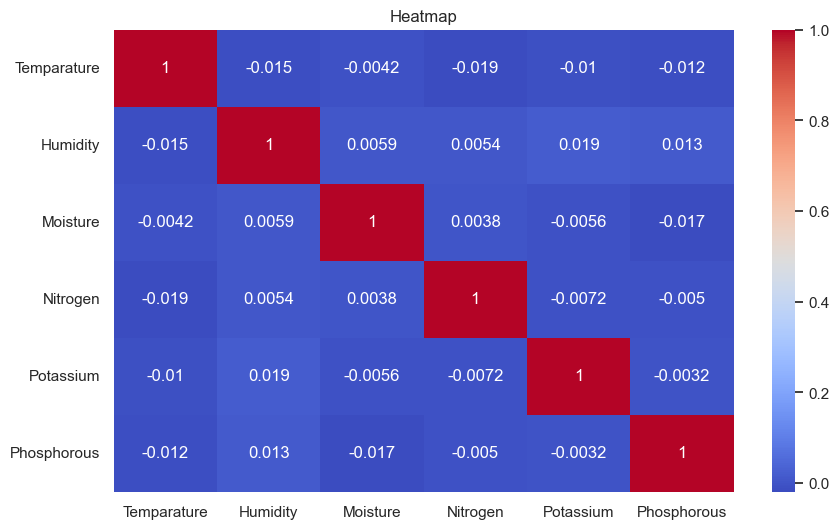

In [23]:
# Heatmap 
plt.figure(figsize = (10, 6))
df_corr = df[['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']].corr()
sns.heatmap(df_corr, cmap = 'coolwarm', annot = True)
plt.title("Heatmap")
plt.show()

## Multi-variate Analysis 

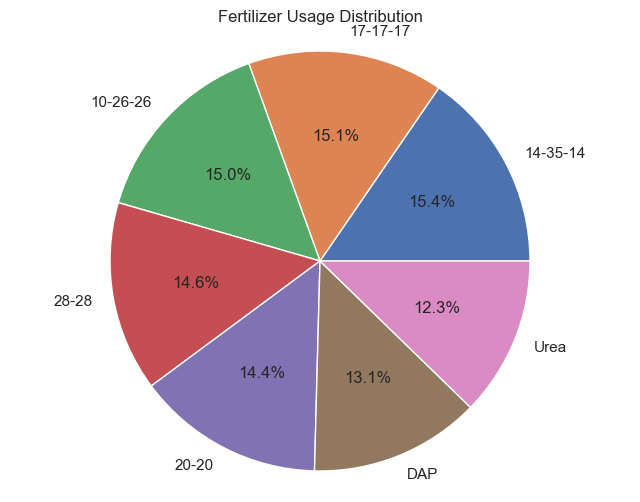

In [25]:
# Piechart
fertilizer_counts = df['FertilizerName'].value_counts()
plt.figure(figsize = (8, 6))
plt.pie(fertilizer_counts, labels = fertilizer_counts.index, autopct = '%1.1f%%')
plt.title('Fertilizer Usage Distribution')
plt.axis('equal')
plt.show()

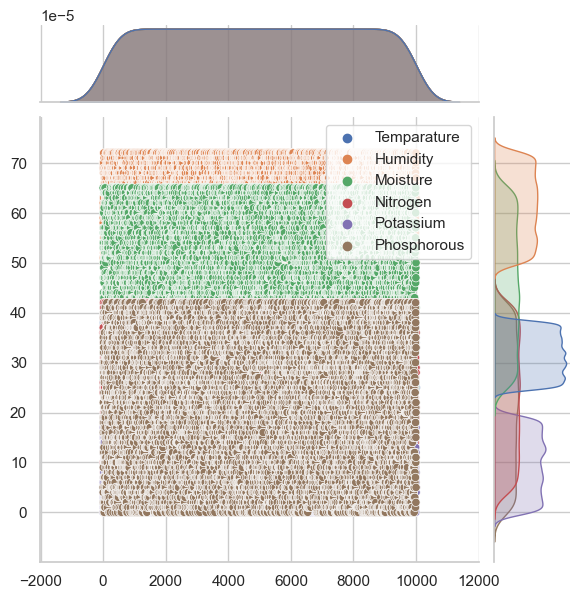

In [26]:
# Jointplot 
sns.jointplot(df)
plt.show()

# Data Preparation 

In [28]:
# Dividing all numeric columns with 100  
for i in num_cols:
    df[i] = df[i]/100

In [29]:
df.head()

,Temparature,Humidity,Moisture,SoilType,CropType,Nitrogen,Potassium,Phosphorous,FertilizerName
0,0.37,0.70,0.36,Clayey,Sugarcane,0.36,0.04,0.05,28-28
1,0.27,0.69,0.65,Sandy,Millets,0.30,0.06,0.18,28-28
2,0.29,0.63,0.32,Sandy,Millets,0.24,0.12,0.16,17-17-17
3,0.35,0.62,0.54,Sandy,Barley,0.39,0.12,0.04,10-26-26
4,0.35,0.58,0.43,Red,Paddy,0.37,0.02,0.16,DAP


In [30]:
df.columns = df.columns.str.strip()  # removes extra spaces 

In [31]:
df.dtypes

Temparature       float64
Humidity          float64
Moisture          float64
SoilType           object
CropType           object
Nitrogen          float64
Potassium         float64
Phosphorous       float64
FertilizerName     object
dtype: object

In [32]:
df.head()

,Temparature,Humidity,Moisture,SoilType,CropType,Nitrogen,Potassium,Phosphorous,FertilizerName
0,0.37,0.70,0.36,Clayey,Sugarcane,0.36,0.04,0.05,28-28
1,0.27,0.69,0.65,Sandy,Millets,0.30,0.06,0.18,28-28
2,0.29,0.63,0.32,Sandy,Millets,0.24,0.12,0.16,17-17-17
3,0.35,0.62,0.54,Sandy,Barley,0.39,0.12,0.04,10-26-26
4,0.35,0.58,0.43,Red,Paddy,0.37,0.02,0.16,DAP


In [33]:
# Encoding the categorical columns 
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(f"\nColumn: {col}")
    for i, cls in enumerate(le.classes_):
        print(f"{cls} → {i}")


Column: SoilType
Black → 0
Clayey → 1
Loamy → 2
Red → 3
Sandy → 4

Column: CropType
Barley → 0
Cotton → 1
Ground Nuts → 2
Maize → 3
Millets → 4
Oil seeds → 5
Paddy → 6
Pulses → 7
Sugarcane → 8
Tobacco → 9
Wheat → 10

Column: FertilizerName
10-26-26 → 0
14-35-14 → 1
17-17-17 → 2
20-20 → 3
28-28 → 4
DAP → 5
Urea → 6


In [34]:
# Setting X, y values 
X = df.drop('FertilizerName', axis = 1)
y = df['FertilizerName']

# Model Buiding 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
X_train

,Temparature,Humidity,Moisture,SoilType,CropType,Nitrogen,Potassium,Phosphorous
1561,0.33,0.51,0.58,4,6,0.11,0.09,0.26
1670,0.26,0.58,0.45,4,0,0.24,0.19,0.36
6087,0.36,0.70,0.58,3,8,0.20,0.06,0.25
6669,0.30,0.67,0.62,1,10,0.18,0.06,0.29
5933,0.38,0.64,0.30,4,3,0.24,0.17,0.15
...,...,...,...,...,...,...,...,...
5734,0.34,0.55,0.43,4,6,0.18,0.06,0.16
5191,0.29,0.71,0.52,2,5,0.14,0.05,0.25
5390,0.37,0.64,0.36,0,9,0.04,0.05,0.26
860,0.34,0.72,0.43,0,10,0.15,0.07,0.03


In [38]:
y_test

6252    1
4684    1
1731    5
4742    0
4521    5
       ..
8285    1
7853    2
1095    4
6929    6
9255    5
Name: FertilizerName, Length: 2001, dtype: int64

In [39]:
# # xgboost classifier 
model_xgb = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')
model_xgb.fit(X_train, y_train)
model_xgb.score(X_train, y_train)

0.958125

In [40]:
model_xgb.fit(X_test, y_test)
model_xgb.score(X_test, y_test)

1.0

# Model Evaluation 

In [42]:
y_pred = model_xgb.predict(X_test)

In [43]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[284,   0,   0,   0,   0,   0,   0],
       [  0, 275,   0,   0,   0,   0,   0],
       [  0,   0, 309,   0,   0,   0,   0],
       [  0,   0,   0, 300,   0,   0,   0],
       [  0,   0,   0,   0, 318,   0,   0],
       [  0,   0,   0,   0,   0, 279,   0],
       [  0,   0,   0,   0,   0,   0, 236]])

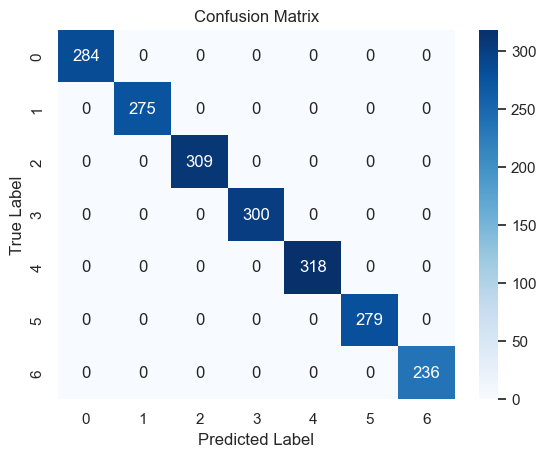

In [44]:
# Heatmap
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
# calssification report 
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).transpose()
report_df.head()

,precision,recall,f1-score,support
0,1.0,1.0,1.0,284.0
1,1.0,1.0,1.0,275.0
2,1.0,1.0,1.0,309.0
3,1.0,1.0,1.0,300.0
4,1.0,1.0,1.0,318.0


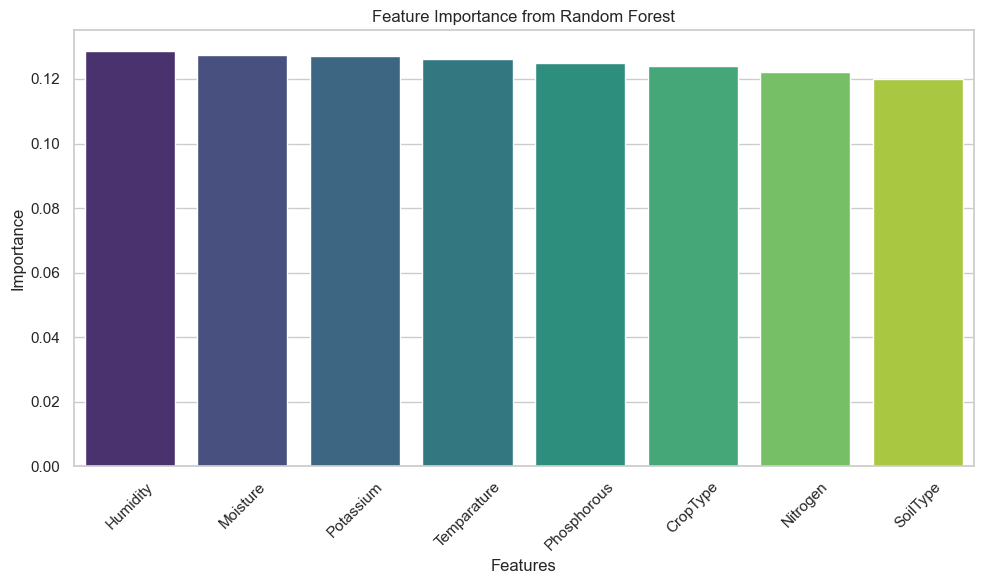

In [46]:
# Feature Importance 
imp_fea = model_xgb.feature_importances_
fea = X_train.columns

imp_fea_df = pd.DataFrame({
    'Features': fea,
    'Importance': imp_fea
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(data = imp_fea_df, x = 'Features', y = 'Importance', palette = 'viridis')
plt.xticks(rotation = 45)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [47]:
# pickle.dump(model_xgb, open('fertilizer_pred_model.pkl', 'wb'))